<a href="https://colab.research.google.com/github/ksdkamesh99/LowLightEnhancer/blob/master/model_gradienttape.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
cd /content/drive/My Drive/LowLightEnhancement

/content/drive/My Drive/LowLightEnhancement


In [4]:
import tensorflow as tf
import keras
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
img_high=np.load("image_high.npy")

In [6]:
img_low=np.load("image_low.npy")

In [7]:
img_low=img_low/255
img_high=img_high/255

In [8]:
img_high.shape

(1485, 96, 96, 3)

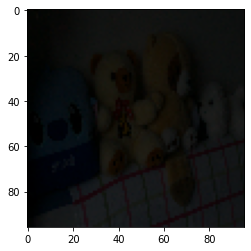

In [9]:
plt.imshow(img_low[0])

## Illumination Mask Network

In [10]:
input_layer_1=keras.layers.Input(shape=(96,96,3))

In [11]:
top=keras.layers.Conv2D(64,kernel_size=(3,3),input_shape=(96,96,3),activation='relu')(input_layer_1)
top=keras.layers.Conv2D(64,kernel_size=(3,3),activation='relu')(top)

In [12]:

top.get_shape

<bound method Tensor.get_shape of <tf.Tensor 'conv2d_1/Relu:0' shape=(None, 92, 92, 64) dtype=float32>>

In [13]:

bottom_inp=input_layer_1
bottom_resize=tf.keras.layers.Lambda(
    lambda img: tf.image.resize(img,(144,144),method='nearest',antialias=True)
)(bottom_inp)

In [14]:
bottom=keras.layers.Conv2D(64,kernel_size=(3,3),input_shape=(96,96,3),activation='relu')(bottom_resize)
bottom=keras.layers.Conv2D(64,kernel_size=(3,3),activation='relu')(bottom)
bottom=keras.layers.Conv2D(64,kernel_size=(3,3),activation='relu')(bottom)


In [15]:
bottom.get_shape()

TensorShape([None, 138, 138, 64])

In [16]:
bottom=keras.layers.experimental.preprocessing.Resizing(92,92,interpolation='nearest')(bottom)

In [17]:
bottom.get_shape()

TensorShape([None, 92, 92, 64])

In [18]:
top.get_shape()

TensorShape([None, 92, 92, 64])

In [19]:
merged=keras.layers.concatenate([top,bottom])

In [20]:
merged

<tf.Tensor 'concatenate/concat:0' shape=(None, 92, 92, 128) dtype=float32>

In [21]:
merged=keras.layers.Conv2D(32,kernel_size=(7,7),activation='relu')(merged)
merged=keras.layers.Conv2D(8,kernel_size=(1,1),activation='relu')(merged)
merged=keras.layers.Conv2D(1,kernel_size=(5,5),activation='relu')(merged)

In [22]:
merged.get_shape()

TensorShape([None, 82, 82, 1])

In [23]:
model_illumination_mask=keras.models.Model(inputs=input_layer_1,outputs=merged)

In [24]:
model_illumination_mask.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 144, 144, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 142, 142, 64) 1792        lambda[0][0]                     
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 140, 140, 64) 36928       conv2d_2[0][0]                   
_______________________________________________________________________________________

# Illumination Map 

In [25]:
merged=keras.layers.experimental.preprocessing.Resizing(96,96,interpolation='nearest')(merged)

In [26]:
merged.get_shape

<bound method Tensor.get_shape of <tf.Tensor 'resizing_1/resize/ResizeNearestNeighbor:0' shape=(None, 96, 96, 1) dtype=float32>>

In [27]:
input_layer_2=keras.layers.Input(shape=(96,96,3))

In [28]:
merged=keras.layers.Concatenate()([input_layer_2,merged])

In [29]:
merged

<tf.Tensor 'concatenate_1/concat:0' shape=(None, 96, 96, 4) dtype=float32>

In [30]:
def ieb(input_feature):
  ieb1=keras.layers.Conv2D(32,kernel_size=(3,3),activation='relu')(input_feature)
  ieb1=keras.layers.Conv2D(32,kernel_size=(3,3),activation='relu')(ieb1)
  max_pool=keras.layers.GlobalMaxPooling2D()(ieb1)
  avg_pool=keras.layers.GlobalAveragePooling2D()(ieb1)
  dense1=keras.layers.Dense(8,activation='relu')
  dense2=keras.layers.Dense(32,activation='sigmoid')
  max_pool=dense1(max_pool)
  max_pool=dense2(max_pool)
  avg_pool=dense1(avg_pool)
  avg_pool=dense2(avg_pool)
  max_pool=keras.layers.Lambda(
    lambda image: keras.backend.expand_dims(keras.backend.expand_dims(image,axis=1),axis=1))(max_pool)
  avg_pool=keras.layers.Lambda(
    lambda image: keras.backend.expand_dims(keras.backend.expand_dims(image,axis=1),axis=1))(avg_pool)
  channel=keras.layers.Add()([max_pool,avg_pool])
  ieb1=keras.layers.Multiply()([ieb1,channel])
  max_pool_s=tf.keras.layers.Lambda(
    lambda x: keras.backend.max(x,axis=3,keepdims=True))(ieb1)
  avg_pool_s=keras.layers.Lambda(
    lambda x: keras.backend.mean(x,axis=3,keepdims=True))(ieb1)
  concat_slayers=keras.layers.Concatenate(axis=3)([avg_pool_s,max_pool_s])
  spacial=keras.layers.Conv2D(1,7,activation='sigmoid')(concat_slayers)
  spacial=keras.layers.experimental.preprocessing.Resizing(92,92,interpolation='nearest')(spacial)
  ieb1=keras.layers.Multiply()([ieb1,spacial])
  ieb1=keras.layers.BatchNormalization()(ieb1)
  ieb1=keras.layers.Activation('relu')(ieb1)
  ieb1=keras.layers.experimental.preprocessing.Resizing(96,96,interpolation='nearest')(ieb1)
  return ieb1


  



In [31]:
ieb_1=ieb(merged)

In [32]:
ieb_2=ieb(ieb_1)

In [33]:
ieb_3=ieb(ieb_2)

In [34]:
ieb_4=ieb(ieb_3)

In [35]:
ieb_5=ieb(ieb_4)

In [36]:
added_ieb=keras.layers.concatenate([ieb_1,ieb_2,ieb_3,ieb_4,ieb_5])

In [37]:
added_ieb

<tf.Tensor 'concatenate_7/concat:0' shape=(None, 96, 96, 160) dtype=float32>

In [38]:

impnet=keras.layers.Conv2D(32,(7,7),activation='relu')(added_ieb)

In [39]:
impnet=keras.layers.Conv2D(8,(1,1),activation='relu')(impnet)

In [40]:
impnet=keras.layers.Conv2D(1,(5,5),activation='sigmoid')(impnet)

In [41]:
impnet=keras.layers.experimental.preprocessing.Resizing(96,96,interpolation='nearest')(impnet)

In [42]:
impnet

<tf.Tensor 'resizing_12/resize/ResizeNearestNeighbor:0' shape=(None, 96, 96, 1) dtype=float32>

# S/L Block 

In [43]:
'''impnet=keras.layers.Lambda(
    lambda x: x+keras.backend.constant(0.001)
)(impnet)'''

'impnet=keras.layers.Lambda(\n    lambda x: x+keras.backend.constant(0.001)\n)(impnet)'

In [44]:
input_layer_3=keras.layers.Input(shape=(96,96,3))

In [45]:
s_l=keras.layers.Lambda(
    lambda input:input[0]/input[1]
)([input_layer_3,impnet])

In [46]:
s_l

<tf.Tensor 'lambda_21/truediv:0' shape=(None, 96, 96, 3) dtype=float32>

# Correction Network

In [47]:
def correction_network(input_feature):
  conv1=keras.layers.Conv2D(64,kernel_size=(3,3),strides=(1,1),activation='relu')(input_feature)
  conv2=keras.layers.Conv2D(32,kernel_size=(3,3),strides=(1,1),activation='relu')(conv1)
  conv3=keras.layers.Conv2D(16,kernel_size=(3,3),strides=(1,1),activation='relu')(conv2)
  conv4=keras.layers.Conv2D(8,kernel_size=(3,3),strides=(1,1),activation='relu')(conv3)
  conv5=keras.layers.Conv2D(3,kernel_size=(3,3),strides=(1,1),activation='sigmoid')(conv4)
  conv5=keras.layers.experimental.preprocessing.Resizing(96,96,interpolation='nearest')(conv5)
  return conv5

In [48]:
final_output=correction_network(s_l)

# Custom Loss Function

In [49]:
import loss as l

In [50]:
import keras.backend as K

In [51]:
def enhancement_loss(x,y):
  x=K.cast(x,dtype='float32')
  y=K.cast(y,dtype='float32')
  norm=tf.norm(x-y)
  return norm

In [52]:
enhancement_loss(img_low[0],img_high[0])

<tf.Tensor: shape=(), dtype=float32, numpy=78.62597>

In [53]:

def color_loss(x,y):
  
  x=K.cast(x,dtype='float32')
  y=K.cast(y,dtype='float32')
  cosine_loss = keras.losses.CosineSimilarity()(x,y)
  colorloss=1-cosine_loss
  return colorloss

In [54]:
color_loss(img_low[0],img_high[0])

<tf.Tensor: shape=(), dtype=float32, numpy=1.9773979>

In [55]:
sobelFilter = K.variable([[[[1.,  1.]], [[0.,  2.]],[[-1.,  1.]]],
                      [[[2.,  0.]], [[0.,  0.]],[[-2.,  0.]]],
                      [[[1., -1.]], [[0., -2.]],[[-1., -1.]]]])


In [56]:
def expandedSobel(inputTensor):
    inputChannels = K.reshape(K.ones_like(inputTensor[0,0,0,:]),(1,1,-1,1))
    return sobelFilter * inputChannels



In [57]:
def squareSobelLoss(yTrue,yPred):
  
  yTrue=K.cast(yTrue,dtype='float32')
  yPred=K.cast(yPred,dtype='float32')
  filt = expandedSobel(yTrue)
  squareSobelTrue =K.square(K.depthwise_conv2d(yTrue,filt))
  squareSobelPred =K.square(K.depthwise_conv2d(yPred,filt))
  newShape = K.shape(squareSobelTrue)
  newShape = K.concatenate([newShape[:-1],
                              newShape[-1:]//2,
                              K.variable([2],dtype='int32')])
  squareSobelTrue = K.sum(K.reshape(squareSobelTrue,newShape),axis=-1)
  squareSobelPred = K.sum(K.reshape(squareSobelPred,newShape),axis=-1)
  return K.mean(K.abs(squareSobelTrue - squareSobelPred))


In [58]:

def max_rgb_filter(img):
  # img=tf.keras.preprocessing.image.img_to_array(img)
  
  r=img[:,:,:,0]
  g=img[:,:,:,1]
  b=img[:,:,:,2]
  max_c=tf.maximum(K.maximum(r,g),b)
  '''
  b_broadcast = K.zeros(K.shape(r), dtype=r.dtype)
  bool_r=K.less(r,max)
  bool_g=K.less(g,max)
  bool_b=K.less(b,max)
  r=K.switch(bool_r,b_broadcast,r)
  g=K.switch(bool_g,b_broadcast,g)
  b=K.switch(bool_b,b_broadcast,b)
  # print(K.shape(r))
  r=K.expand_dims(r)
  g=K.expand_dims(g)
  b=K.expand_dims(b)
  img=K.concatenate([r,g,b],axis=-1)
  # print(K.shape(img))
  # img_rgb_filter=tf.keras.preprocessing.image.array_to_img(img)
  return img'''
  return tf.expand_dims(max_c,axis=-1)

def light_mask_loss(input_img,pred_img,true_img):
  pred_img=tf.cast(pred_img,tf.uint8)
  true_img=tf.cast(true_img,tf.uint8)
  input_img=tf.cast(input_img,tf.uint8)
  m_i=max_rgb_filter(input_img)
  m_t=max_rgb_filter(true_img)
  # m_t=m_t+K.constant(0.001,shape=m_t.shape,dtype=m_t.dtype)
  m_div_it=tf.divide(m_i,m_t)
  m_div_it=tf.cast(m_div_it,tf.uint8)
  light_mask=tf.subtract(pred_img,m_div_it)
  light_mask=tf.cast(light_mask,tf.float32)
  lightmask_loss=tf.norm(light_mask)
  return lightmask_loss

In [59]:
a1=max_rgb_filter(tf.expand_dims(img_low[1],axis=0))
a2=max_rgb_filter(tf.expand_dims(img_high[1],axis=0))

In [60]:
b=a1/a2
img_low[0]-b

<tf.Tensor: shape=(1, 96, 96, 3), dtype=float64, numpy=
array([[[[-0.00823529, -0.00039216, -0.01215686],
         [-0.00028011, -0.00420168, -0.00812325],
         [ 0.00571185, -0.00213129, -0.00997442],
         ...,
         [ 0.0246646 ,  0.03250774,  0.02858617],
         [ 0.02787493,  0.03571807,  0.02787493],
         [ 0.03443329,  0.03051172,  0.03051172]],

        [[-0.00951189, -0.00166875, -0.01343346],
         [-0.01096257, -0.00311943, -0.01096257],
         [-0.00472189,  0.00704282, -0.00472189],
         ...,
         [ 0.0302521 ,  0.0302521 ,  0.0302521 ],
         [ 0.00361991,  0.00361991,  0.01538462],
         [ 0.03051172,  0.03443329,  0.03051172]],

        [[-0.02039216, -0.02039216, -0.03215686],
         [ 0.01176471,  0.02352941,  0.01568627],
         [ 0.01176471,  0.02745098,  0.01568627],
         ...,
         [-0.02009804, -0.01617647, -0.02009804],
         [-0.0022409 ,  0.00560224,  0.00560224],
         [ 0.03963964,  0.03571807,  0.0317965 ]

In [61]:
def custom_loss_wrapper(input_tensor):
  def custom_loss(y_true,y_pred):
    # lm_loss=light_mask_loss(input_img=input_tensor,pred_img=y_pred,true_img=y_true)
    # print(lm_loss)
    e_loss=enhancement_loss(y_true,y_pred)
    c_loss=color_loss(y_true,y_pred)
    s_loss=squareSobelLoss(y_true,y_pred)
    total_loss=e_loss+s_loss*0.2+0.2*c_loss
    # total_loss=total_loss+(10*lm_loss)
    return total_loss
  return custom_loss

# Model

In [62]:
model=keras.models.Model(inputs=[input_layer_1,input_layer_2,input_layer_3],outputs=final_output)

In [63]:
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 144, 144, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 142, 142, 64) 1792        lambda[0][0]                     
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 140, 140, 64) 36928       conv2d_2[0][0]                   
_______________________________________________________________________________________

# Plot a DL Model

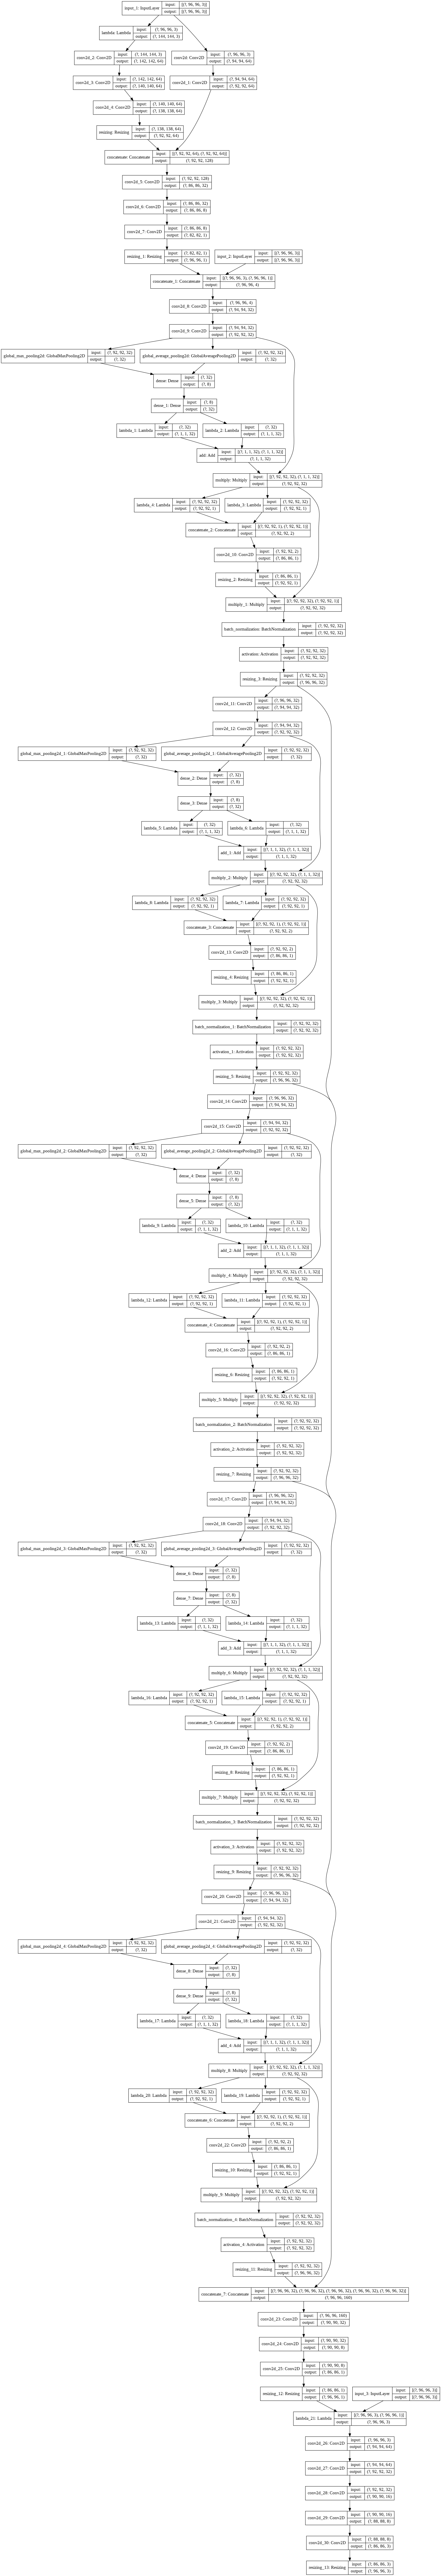

In [64]:
keras.utils.plot_model(model,show_shapes=True,show_layer_names=True)

# Model Compile

In [67]:
opt=tf.optimizers.Adam(0.01)

In [83]:
EPOCHS=10
BATCH=28

In [92]:
for i in range(EPOCHS):
    b=0
    for j in range(0,img_high.shape[0],BATCH):
        b=b+1
        img_inp=img_low[j:j+BATCH]
        img_out=img_high[j:j+BATCH]
        with tf.GradientTape() as tape:
          img_pred=model([img_inp,img_inp,img_inp])
          lm_loss=light_mask_loss(input_img=img_inp,pred_img=img_pred,true_img=img_out)
          e_loss=enhancement_loss(img_out,img_pred)
          c_loss=color_loss(img_out,img_pred)
          s_loss=squareSobelLoss(img_out,img_pred)
          total_loss=e_loss+s_loss*0.2+1*c_loss+lm_loss
          print(i,' ',b,' ',total_loss.numpy())
        grads = tape.gradient(total_loss, model.trainable_variables)
        opt.apply_gradients(zip(grads, model.trainable_variables))
    



0   1   1306.9813
0   2   213.01178
0   3   149.04758
0   4   150.83247
0   5   1653.374
0   6   251.21469
0   7   232.0226
0   8   218.8335
0   9   177.24615
0   10   202.67125
0   11   1265.7609
0   12   181.30928
0   13   142.9386
0   14   2714.8894
0   15   148.80844
0   16   141.48929
0   17   4569.462
0   18   11330.393
0   19   15421.457
0   20   3839.939
0   21   17943.557
0   22   8870.65
0   23   10072.373
0   24   12324.399
0   25   14573.773
0   26   5281.9907
0   27   23923.547
0   28   8691.374
0   29   6582.668
0   30   9347.817
0   31   13585.248
0   32   11486.5
0   33   10923.011
0   34   27337.506
0   35   17092.365
0   36   37808.66


KeyboardInterrupt: ignored

In [85]:
model

In [86]:
img=np.expand_dims(img_low[7],axis=0)

In [87]:

img.shape

(1, 96, 96, 3)

In [88]:
a=model.predict(x=[img,img,img])

In [89]:
import matplotlib.pyplot as plt


In [90]:
a

array([[[[0.48103717, 0.45413572, 0.3507284 ],
         [0.47403988, 0.44609857, 0.33934763],
         [0.46975982, 0.4411309 , 0.33264443],
         ...,
         [0.45194757, 0.41782802, 0.3054425 ],
         [0.45614675, 0.42299983, 0.3117442 ],
         [0.45739242, 0.4243948 , 0.31431356]],

        [[0.47428373, 0.4458517 , 0.340416  ],
         [0.46855587, 0.4392911 , 0.33086854],
         [0.46623966, 0.43689492, 0.32724252],
         ...,
         [0.45127067, 0.41691875, 0.3045322 ],
         [0.45470485, 0.42149395, 0.3098385 ],
         [0.4543451 , 0.42148718, 0.3103479 ]],

        [[0.4680959 , 0.43779424, 0.33050948],
         [0.4637109 , 0.4325857 , 0.3229317 ],
         [0.4631687 , 0.4327087 , 0.3223993 ],
         ...,
         [0.4509371 , 0.41637665, 0.3038869 ],
         [0.4537808 , 0.4203674 , 0.30839384],
         [0.452398  , 0.41966543, 0.30766666]],

        ...,

        [[0.5832351 , 0.5758667 , 0.51577055],
         [0.57234526, 0.56318235, 0.49791643]

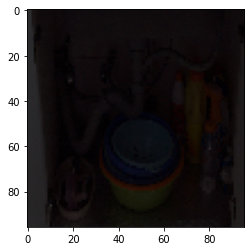

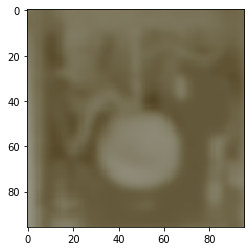

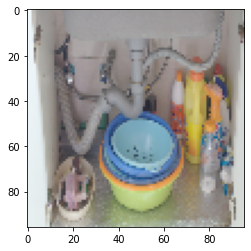

In [91]:
plt.imshow(img[0])
plt.show()
plt.imshow(a[0])
plt.show()
plt.imshow(img_high[7])
plt.show()

In [ ]:


!nvidia-smi

Mon Nov  9 15:13:16 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.32.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0    77W / 149W |  10868MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------